# Travelling Salesman Problem with subtour elimination
This example shows how to solve a TSP  by eliminating subtours using:

1. amplpy (defining the subtour elimination constraint in AMPL and instantiating it appropriately)
2. ampls (adding cuts directly from the solver callback)

### Options

In [40]:
SOLVER = "xpress"
SOLVER_OPTIONS = ['outlev=1']
USE_CALLBAKCS = True
PLOTSUBTOURS = True
TSP_FILE = "../tsp/a280.tsp"

import sys
sys.path.append('D:/Development/ampl/solvers-private/build/vs64/bin')

### Imports

In [41]:
# Import utilities
from amplpy import AMPL, DataFrame  # pip install amplpy
if SOLVER == "gurobi":
    import amplpy_gurobi as ampls   # pip install ampls-gurobi
elif SOLVER == "cplex":
    import amplpy_cplex as ampls    # pip install ampls-
elif SOLVER == "xpress":
    import amplpy_xpress as ampls    # pip install ampls-gurobi
import tsplib95 as tsp              # pip install tsplib95
import matplotlib.pyplot as plt     # pip install matplotlib
import matplotlib.colors as colors
from time import time
plt.rcParams['figure.dpi'] = 200

ImportError: DLL load failed while importing _amplpy_xpress_swig: The specified module could not be found.

### Register jupyter magics for AMPL

In [ ]:
from amplpy import register_magics
register_magics('_ampl_cells')  # Store %%ampl cells in the list _ampl_cells

### Define TSP model in AMPL

In [ ]:
%%ampl
set NODES ordered;
param hpos {NODES};
param vpos {NODES};

set PAIRS := {i in NODES, j in NODES: ord(i) < ord(j)};

param distance {(i,j) in PAIRS}
   := sqrt((hpos[j]-hpos[i])**2 + (vpos[j]-vpos[i])**2);

var X {PAIRS} binary;

minimize Tour_Length: sum {(i,j) in PAIRS} distance[i,j] * X[i,j];

subject to Visit_All {i in NODES}:
   sum {(i, j) in PAIRS} X[i,j] + sum {(j, i) in PAIRS} X[j,i] = 2;

Function to load TSP data files and return a dictionary of (nodeid : coordinate)

In [ ]:
def getDictFromTspFile(tspFile):
    p = tsp.load(tspFile)
    if not p.is_depictable:
        print("Problem is not depictable!")

    # Amendments as we need the nodes lexographically ordered
    nnodes = len(list(p.get_nodes()))
    i = 0
    while nnodes>1:
        nnodes = nnodes/10
        i+=1
    formatString = f"{{:0{i}d}}"
    nodes = {formatString.format(value) : p.node_coords[index+1] for index, value in enumerate(p.get_nodes())}
    return nodes

Create AMPL object with amplpy and load model and data

In [ ]:
# Get the model from the cell above
tsp_model = _ampl_cells[0]

# Load model in AMPL
ampl = AMPL()
ampl.eval(tsp_model)
ampl.option["solver"] = SOLVER
ampl.option[SOLVER + "_options"] = ' '.join(SOLVER_OPTIONS)

# Set problem data from tsp file
nodes = getDictFromTspFile(TSP_FILE)

# Pass them to AMPL using a dataframe
df = DataFrame(index=[('NODES')], columns=['hpos', 'vpos'])
df.setValues(nodes)
ampl.setData(df, "NODES")

# Set some globals that never change during the execution of the problem
NODES = set(nodes.keys())
CPOINTS = {node : complex(coordinate[0], coordinate[1]) for (node, coordinate) in nodes.items()}

Define some helpers functions to plot the tours

In [ ]:
def plotTours(tours: list, points_coordinate: dict):
    # Plot all the tours in the list each with a different color
    colors = ['b', 'g', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tourCoordinates = [points_coordinate[point.strip("'")] for point in tour]
        color = colors[i % len(colors)]
        plot_all(tourCoordinates, color = color)
    plt.show()

def plot_all(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], 's', alpha=alpha, color=color)
    
def plotline(points, style='o-', alpha=1, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, style, alpha=alpha, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

Define some helper functions to help with the graphs (e.g. get the subtour given a set of arcs)

In [ ]:
# Graphs helper routines
def trasverse(node, arcs: set, allnodes: set, subtour = None) -> list:
    # Trasverses all the arcs in the set arcs, starting from node
    # and returns the tour
    if not subtour:
        subtour = list()
    # Find arcs involving the current node
    myarcs = [(i,j) for (i,j) in arcs if node == i or node == j]
    if len(myarcs) == 0:
        return 
    # Append the current node to the current subtour
    subtour.append(node)

    # Use the first arc found
    myarc = myarcs[0]
    # Find destination (or origin) node
    destination = next(i for i in myarc if i != node)
    # Remove from arcs and nodes to visit
    arcs.remove(myarc)
    if node in allnodes:
        allnodes.remove(node)

    trasverse(destination, arcs, allnodes, subtour)
    return subtour


def findSubTours(arcs: set, allnodes: set):
    """Find all the subtours defined by a set of arcs and
       return them as a list of list
    """
    subtours = list()
    allnodes = allnodes.copy()
    while len(allnodes) > 0:
        l = trasverse(next(iter(allnodes)), arcs, allnodes)
        subtours.append(l)
    return subtours

AMPLPY implementation of sub-tours elimination

In [ ]:
def amplSubTourElimination(ampl: AMPL):
    # Add the constraint and the needed parameters
    subToursAMPL = """param nSubtours >= 0 integer, default 0;
    set SUB {1..nSubtours} within NODES;

    subject to Subtour_Elimination {k in 1..nSubtours}:
    sum {i in SUB[k], j in NODES diff SUB[k]} 
    if (i, j) in PAIRS then X[i, j] else X[j, i] >= 2;"""
    ampl.eval(subToursAMPL)

    nSubtoursParam = ampl.getParameter("nSubtours")
    SubtoursSet = ampl.getSet("SUB")

    allsubtours = list()
    while True: # Repeat until the solution contains only one tour
        ampl.solve()
        # Get solution
        ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
        ARCS = set([(i, j) for (i, j, k)in ARCS.toList()])
        subtours = findSubTours(ARCS, NODES)
        # If we have only one tour, the solution is valid
        if len(subtours) <= 1:
            break
        print(f"Found {len(subtours)} subtours, plotting them and adding cuts")
        if PLOTSUBTOURS:
            plotTours(subtours, CPOINTS)
        # Else add the current tours to the list of subtours
        allsubtours.extend(subtours)
        # And add those to the constraints by assigning the values to
        # the parameter and the set
        nSubtoursParam.set(len(allsubtours))
        for (i, tour) in enumerate(allsubtours):
            SubtoursSet[i+1].setValues(tour)

ampls callbacks implementation of subtours elimination

In [ ]:
# Callback class that actually add the cuts if subtours are found in a solution
class MyCallback(ampls.GenericCallback):
    def __init__(self): 
        # Constructor, simply sets the iteration number to 0
        super().__init__()
        self.iteration = 0 
    def run(self):
        try:
            # For each solution
            if self.getAMPLWhere() == ampls.Where.MIPSOL:
                self.iteration += 1
                print(f"/nIteration {self.iteration}: Finding subtours")
                sol = self.getSolutionVector()
                arcs = [xvars[i] for i, value in enumerate(sol) if value > 0]
                subTours = findSubTours(set(arcs), set(vertices))
                if len(subTours) ==1:
                    print("No subtours detected. Not adding any cut")
                    return 0
                print(f"Adding {len(subTours)} cuts")
                if PLOTSUBTOURS:
                    plotTours(subTours, CPOINTS)
                for subTour in subTours:
                    st1 = set(subTour)
                    nst1 = set(vertices) - st1
                    externalArcs = [(i, j) if i < j else (j, i) for i in st1 for j in nst1]
                    varsExternalArcs = [xinverse[i, j] for (i, j) in externalArcs]
                    coeffs = [1 for i in range(len(varsExternalArcs))]
                    if PLOTSUBTOURS:
                        print("Adding cut for subtour:", st1)
                    self.addLazyIndices(varsExternalArcs, coeffs, ampls.CutDirection.GE, 2)
                    if len(subTours) == 2:
                        return 0
                print("Continue solving")
            return 0
        except Exception as e:
            print('Error:', e)
            return 1

In [ ]:
# Global variables to store entities needed by the callbacks
# that never change
xvars = None
xinverse = None
vertices = None
def solverSubTourElimination(ampl: AMPL, solver, solver_options):
    global xvars, xinverse, vertices
    # Export the model using ampls
    model = ampl.exportModel(solver, solver_options)
    model.enableLazyConstraints()

    # Get the global maps between solver vars and AMPL entities
    varMap = model.getVarMapFiltered("X")
    #print("varMap:", varMap)
    inverse = model.getVarMapInverse()
    xvars = {index: ampls.var2tuple(var)[1:] for var, index in varMap.items()}
    xinverse = {ampls.var2tuple(var)[1:]: index for index, var in inverse.items()}
    vertices = list(sorted(set([x[0] for x in xvars.values()] + [x[1] for x in xvars.values()])))

    # Assign the callback
    callback = MyCallback()
    model.setCallback(callback)
    print("Start optimization")
    # Start the optimization
    model.optimize()
    # Import the solution back to AMPL
    ampl.importSolution(model)

Script running the optimization

In [ ]:
t0 = time()
if not USE_CALLBAKCS:
    amplSubTourElimination(ampl)
else:
    solverSubTourElimination(ampl, SOLVER, SOLVER_OPTIONS)

AttributeError: 'NoneType' object has no attribute 'enableLazyConstraints'

Get the solution, print it and display it

['010', '011', '012', '013', '015', '014', '024', '023', '025', '022', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '060', '061', '118', '062', '063', '059', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '076', '075', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '116', '117', '115', '114', '113', '087', '088', '112', '111', '110', '108', '109', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '174', '173', '172', '171', '170', '169', '168', '167', '166', '165', '164', '163', '162', '161', '175', '160', '159', '158', '157', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '021', '020', '019', '132', '131', '130', '129', '154', '155', '153', '156'

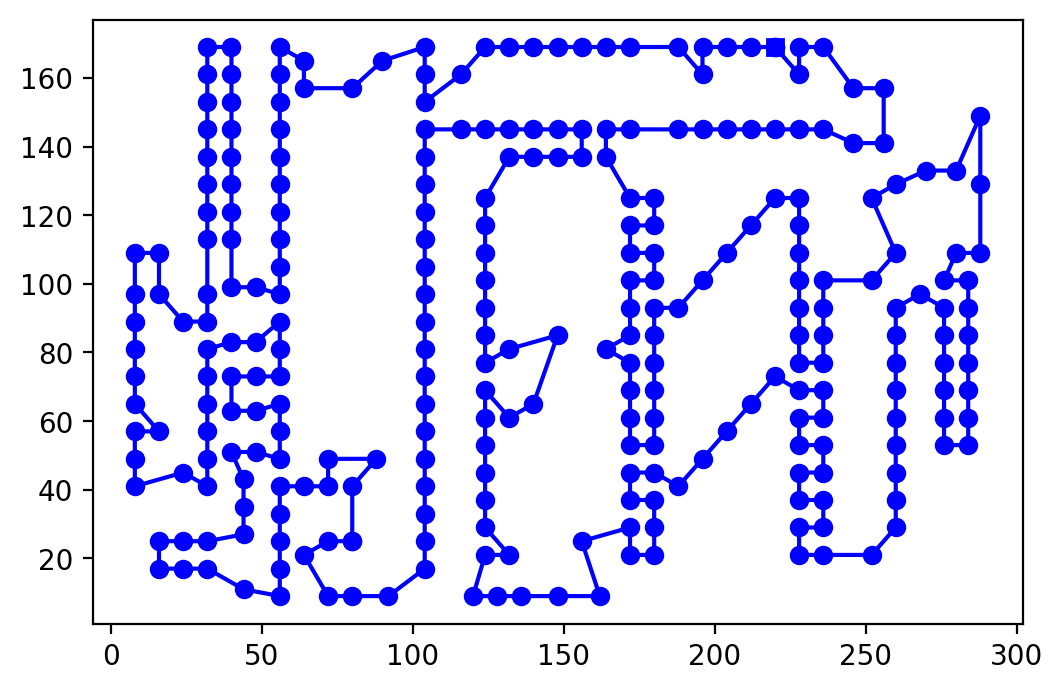

In [ ]:
# Get the solution into ARCS
ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
ARCS = set([(i,j) for (i,j,k) in ARCS.toList()])

# Display it
tours = findSubTours(ARCS, NODES)
for st in tours:
    print(st)
plotTours(tours, CPOINTS)

In [ ]:
ampl.getValue('Tour_Length')

2586.7696475631615

In [ ]:
time()-t0

13.46192479133606